# FCI Triangular Lattice — QGN Analysis

Two-band tight-binding model for the Fractional Chern Insulator on a triangular lattice.
Following **Kourtis, Venderbos & Daghofer, PRB 86, 235118 (2012)**, Eq. (23).

$$H_{\mathrm{kin}}(\mathbf{k}) = 2t \sum_{j=1}^{3} \sigma^j \cos(\mathbf{k}\cdot\mathbf{a}_j)
                                  + 2t' \sum_{j=1}^{3} \sigma^0 \cos(2\mathbf{k}\cdot\mathbf{a}_j)$$

where $\sigma^{1,2,3} = \sigma_{x,y,z}$ act in the 2-site unit cell, and
$\mathbf{a}_{1,2,3}$ are the three NN bond vectors of the triangular lattice
($\mathbf{a}_1 + \mathbf{a}_2 + \mathbf{a}_3 = 0$).

**Dispersion** (Eq. 24):  $\varepsilon_\mathbf{k}^\pm = \pm 2t \sqrt{\sum_j \cos^2(\mathbf{k}\cdot\mathbf{a}_j)}
+ 2t' \sum_j \cos(2\mathbf{k}\cdot\mathbf{a}_j)$

The lower band has Chern number $C = \pm 1$. Near-flat bands are achieved for $t'/t \approx 0.2$.

## 1. Setup

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from qgn.models import fci_triangular_hamiltonian
from qgn.geometry import (diagonalize_model, projection_matrix_from_vecs,
                           berry_curvature_grid, chern_number, quantum_distance)
from qgn.core import nestability_map, nesting_matrix

plt.rcParams.update({'figure.dpi': 100, 'font.size': 11})

# Parameters
t  = 1.0   # NN hopping (energy unit)
tp = 0.2   # third-neighbor hopping t' — near-flat band regime (Fig. 5 of paper)

# Bond vectors of the triangular lattice
a1 = np.array([1.0, 0.0])
a2 = np.array([-0.5,  np.sqrt(3)/2])
a3 = np.array([-0.5, -np.sqrt(3)/2])

# Reciprocal lattice vectors of the 2-site unit cell
# (A1 = a1 - a3 = (3/2, √3/2), A2 = a2 - a3 = (0, √3))
B1 = np.array([4*np.pi/3, 0.0])
B2 = np.array([-2*np.pi/3, 2*np.pi/np.sqrt(3)])

# High-symmetry points in physical k-space
# Γ = (0,0),  M = B1/2,  K = B1/3 + B2/3 ... use standard triangular pts
Gamma = np.array([0.0, 0.0])
M_pt  = np.array([np.pi, np.pi/np.sqrt(3)])   # midpoint of BZ edge
K_pt  = np.array([4*np.pi/3, 0.0])            # BZ corner (= B1)

print(f'Parameters: t = {t},  t\' = {tp}  (t\'/t = {tp/t})')
print(f'Bond vectors:  a1={a1},  a2={a2},  a3={a3}')

Parameters: t = 1.0,  t' = 0.2  (t'/t = 0.2)
Bond vectors:  a1=[1. 0.],  a2=[-0.5        0.8660254],  a3=[-0.5       -0.8660254]


## 2. Band Structure along Γ – M – K – Γ

Compare different $t'/t$ ratios to show how third-neighbor hopping flattens the lower band.

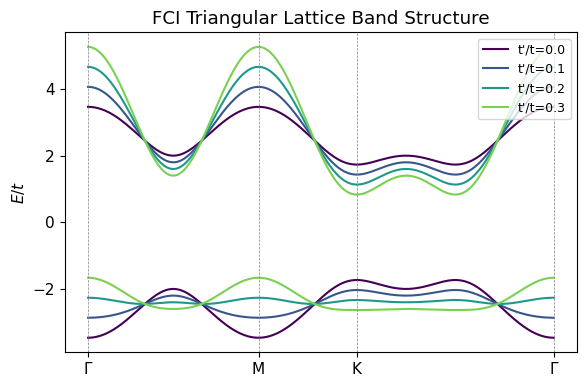

t'/t = 0.2: lower-band width W = 0.1859t,  gap Δ = 3.3962t,  M = Δ/W = 18.3


In [2]:
# Build high-symmetry path: Γ → M → K → Γ
N_seg = 80

def make_path(pts, N):
    segs = []
    for p0, p1 in zip(pts[:-1], pts[1:]):
        segs.append(np.outer(np.linspace(0, 1, N, endpoint=False), p1 - p0) + p0)
    segs.append(pts[-1:])   # include endpoint
    return np.vstack(segs)

k_path = make_path([Gamma, M_pt, K_pt, Gamma], N_seg)
k_dist = np.concatenate([[0], np.cumsum(np.linalg.norm(np.diff(k_path, axis=0), axis=1))])

# Tick marks for high-symmetry points
tick_positions = [0,
                  np.linalg.norm(M_pt - Gamma),
                  np.linalg.norm(M_pt - Gamma) + np.linalg.norm(K_pt - M_pt),
                  k_dist[-1]]
tick_labels = ['Γ', 'M', 'K', 'Γ']

fig, ax = plt.subplots(figsize=(6, 4))
colors = plt.cm.viridis(np.linspace(0, 0.8, 4))
for i, tp_val in enumerate([0.0, 0.1, 0.2, 0.3]):
    Es = np.array([np.linalg.eigvalsh(fci_triangular_hamiltonian(k, t=t, tp=tp_val))
                   for k in k_path])
    for n in range(2):
        ax.plot(k_dist, Es[:, n], color=colors[i],
                lw=1.5, label=f"t'/t={tp_val}" if n == 0 else None)

for xp in tick_positions:
    ax.axvline(xp, color='gray', lw=0.5, ls='--')
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_ylabel('$E / t$')
ax.set_title('FCI Triangular Lattice Band Structure')
ax.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig('../docs/fci_bands.png', dpi=100)
plt.show()

# Bandwidth and gap for default t'/t = 0.2
Es_default = np.array([np.linalg.eigvalsh(fci_triangular_hamiltonian(k, t=t, tp=tp))
                        for k in k_path])
W  = Es_default[:, 0].max() - Es_default[:, 0].min()
gap = Es_default[:, 1].min() - Es_default[:, 0].max()
print(f"t'/t = {tp}: lower-band width W = {W:.4f}t,  gap Δ = {gap:.4f}t,  M = Δ/W = {gap/W:.1f}")

## 3. Berry Curvature & Chern Number

Compute the Berry curvature $\Omega(\mathbf{k})$ of the lower band on the 2D BZ
and the Chern number $C = \frac{1}{2\pi}\int_{\mathrm{BZ}} \Omega\, d^2k$.

Chern number of lower band: C = -1.000  (should be ±1)


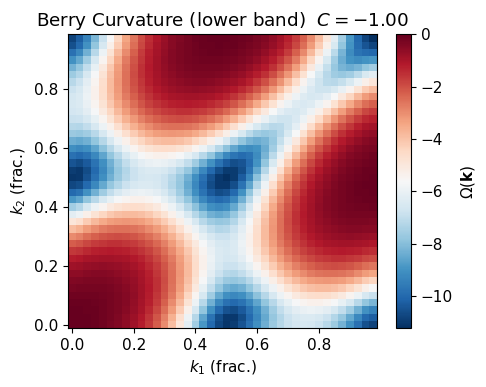

In [3]:
Nk = 40
k1 = np.linspace(0, 1, Nk, endpoint=False)
k2 = np.linspace(0, 1, Nk, endpoint=False)

eigvals_2d = np.zeros((Nk, Nk, 2))
eigvecs_2d = np.zeros((Nk, Nk, 2, 2), dtype=complex)
K1, K2 = np.meshgrid(k1, k2, indexing='ij')

for i in range(Nk):
    for j in range(Nk):
        k_phys = k1[i] * B1 + k2[j] * B2
        e, v = np.linalg.eigh(fci_triangular_hamiltonian(k_phys, t=t, tp=tp))
        eigvals_2d[i, j] = e
        eigvecs_2d[i, j] = v

# Berry curvature and Chern number
dk1 = 1.0 / Nk
dk2 = 1.0 / Nk
Omega = berry_curvature_grid(eigvecs_2d, flat_bands=[0], dk1=dk1, dk2=dk2)
C     = chern_number(eigvecs_2d, flat_bands=[0])

print(f'Chern number of lower band: C = {C:.3f}  (should be ±1)')

# Plot Berry curvature in the BZ (using fractional coords as axes)
fig, ax = plt.subplots(figsize=(5, 4))
pcm = ax.pcolormesh(K1, K2, Omega, cmap='RdBu_r', shading='auto')
plt.colorbar(pcm, ax=ax, label='$\\Omega(\\mathbf{k})$')
ax.set_xlabel('$k_1$ (frac.)')
ax.set_ylabel('$k_2$ (frac.)')
ax.set_title(f'Berry Curvature (lower band)  $C = {C:.2f}$')
plt.tight_layout()
plt.savefig('../docs/fci_berry.png', dpi=100)
plt.show()

## 4. Quantum Distance

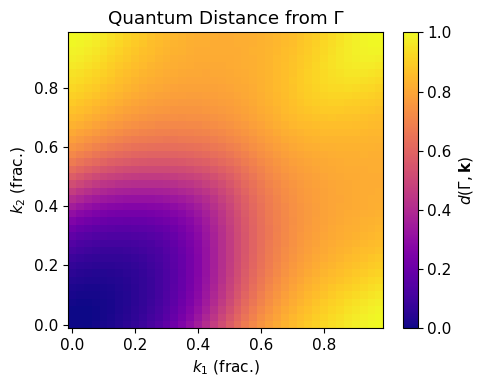

Max quantum distance from Γ: 0.9980  (max = 1 for a 1-band projector)


In [4]:
flat_bands = [0]
P     = projection_matrix_from_vecs(eigvecs_2d.reshape(Nk*Nk, 2, 2), flat_bands)
P_2d  = P.reshape(Nk, Nk, 2, 2)

# Quantum distance from k1=k2=0 to all k points
P0 = P_2d[0, 0]
d_map = np.array([[quantum_distance(P0, P_2d[i, j], n_flat=1)
                   for j in range(Nk)] for i in range(Nk)])

fig, ax = plt.subplots(figsize=(5, 4))
pcm = ax.pcolormesh(K1, K2, d_map, cmap='plasma', shading='auto', vmin=0, vmax=1)
plt.colorbar(pcm, ax=ax, label='$d(\\Gamma, \\mathbf{k})$')
ax.set_xlabel('$k_1$ (frac.)')
ax.set_ylabel('$k_2$ (frac.)')
ax.set_title('Quantum Distance from Γ')
plt.tight_layout()
plt.show()
print(f'Max quantum distance from Γ: {d_map.max():.4f}  (max = 1 for a 1-band projector)')

## 5. QGN Nestability Scan (1D diagonal cut)

Compute $\tilde{\omega}_0^Q = \lambda_{\min}(\Pi^Q)$ along a 1D k-line
to identify preferred nesting wave vectors.

Computing nestability map (p-p)...
Computing nestability map (p-h)...


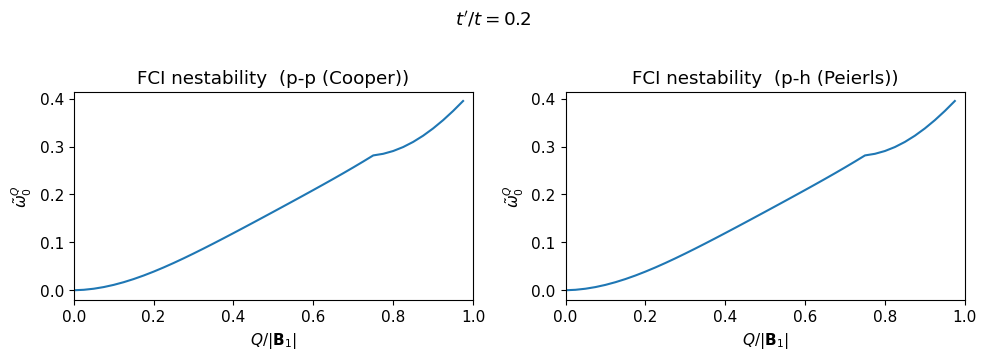

Min p-p nestability = 0.0000 at Q/|B1| = 0.000
Min p-h nestability = 0.0000 at Q/|B1| = 0.000


In [5]:
# 1D k-path along k1 direction (k2 = 0)
Nk1d = 80
k1d   = np.linspace(0, 1, Nk1d, endpoint=False)
k_1d  = np.array([ki * B1 for ki in k1d])   # physical k along B1 direction

H_1d     = lambda k: fci_triangular_hamiltonian(k, t=t, tp=tp)
_, evecs = diagonalize_model(H_1d, k_1d)
P_1d     = projection_matrix_from_vecs(evecs, flat_bands=[0])
Q_1d     = np.eye(2)[None, ...] - P_1d

# Convert Q to physical units along B1: Q_phys = q * |B1|
Q_frac  = np.linspace(0, 1, 40, endpoint=False)
Q_phys  = Q_frac * np.linalg.norm(B1)   # nesting Q in same units as k_1d

# Use the physical |k| grid for nesting
k_grid_1d = np.linspace(0, np.linalg.norm(B1), Nk1d, endpoint=False)

print('Computing nestability map (p-p)...')
omega_pp = nestability_map(P_1d, Q_1d, k_grid_1d, Q_phys, channel='pp')
print('Computing nestability map (p-h)...')
omega_ph = nestability_map(P_1d, Q_1d, k_grid_1d, Q_phys, channel='ph')

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
for ax, omega, label in zip(axes, [omega_pp, omega_ph],
                            ['p-p (Cooper)', 'p-h (Peierls)']):
    ax.plot(Q_frac, omega, color='tab:blue')
    ax.set_xlabel('$Q / |\\mathbf{B}_1|$')
    ax.set_ylabel('$\\tilde{\\omega}_0^Q$')
    ax.set_title(f'FCI nestability  ({label})')
    ax.set_xlim(0, 1)
plt.suptitle(f"$t'/t = {tp/t}$", y=1.02)
plt.tight_layout()
plt.show()

print(f'Min p-p nestability = {omega_pp.min():.4f} at Q/|B1| = {Q_frac[np.argmin(omega_pp)]:.3f}')
print(f'Min p-h nestability = {omega_ph.min():.4f} at Q/|B1| = {Q_frac[np.argmin(omega_ph)]:.3f}')

## 6. Flatness Ratio M vs t'/t

Reproduce the qualitative behavior of Fig. 5(b): $M = \Delta / W$ as a function of $t'/t$.

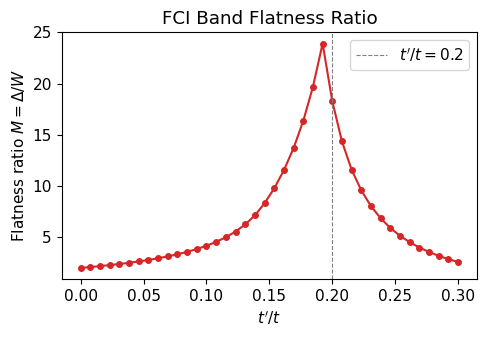

Maximum M = 23.9 at t'/t = 0.192


In [6]:
tp_vals = np.linspace(0, 0.3, 40)
M_vals  = []

for tp_v in tp_vals:
    Es = np.array([np.linalg.eigvalsh(fci_triangular_hamiltonian(k, t=1.0, tp=tp_v))
                   for k in k_path])
    W_v   = Es[:, 0].max() - Es[:, 0].min()
    gap_v = Es[:, 1].min() - Es[:, 0].max()
    M_vals.append(gap_v / W_v if W_v > 1e-6 else np.inf)

fig, ax = plt.subplots(figsize=(5, 3.5))
ax.plot(tp_vals / t, M_vals, 'o-', ms=4, color='tab:red')
ax.axvline(0.2, color='gray', ls='--', lw=0.8, label="$t'/t = 0.2$")
ax.set_xlabel("$t'/t$")
ax.set_ylabel('Flatness ratio $M = \\Delta / W$')
ax.set_title('FCI Band Flatness Ratio')
ax.legend()
plt.tight_layout()
plt.show()

i_max = np.argmax(M_vals)
print(f'Maximum M = {M_vals[i_max]:.1f} at t\'/t = {tp_vals[i_max]:.3f}')